# Previsão de Demanda de Vinhos com Séries Temporais

## 1- Introdução

A **previsão de demanda** é um processo fundamental na gestão de cadeias de suprimentos e negócios, que envolve **estimar a quantidade de um produto ou serviço que os consumidores vão querer em um período futuro**. Utilizando métodos estatísticos e análise de tendências históricas, esta previsão ajuda as empresas a tomar decisões sobre produção, gestão de estoques, planejamento financeiro e marketing. O objetivo é otimizar os recursos da empresa, minimizar custos e desperdícios, garantindo que a oferta esteja alinhada com a demanda futura.

**Vinhos** são produtos que demandam condições apropriadas de armazenamento e transporte para manter suas qualidades e prevenir a degradação. Por isso, é crucial adotar práticas cuidadosas na armazenagem e no transporte dos vinhos para **reduzir perdas no inventário e aumentar a rentabilidade da empresa**.

Embora existam vinhos que se beneficiem do envelhecimento, a grande maioria é elaborada para ser consumida num curto prazo, geralmente desde sua chegada ao mercado até um período que varia de 1 a 3 anos. Isso significa que é vital para as empresas evitar excessos no estoque, o que implica na **necessidade de um gerenciamento eficiente da demanda**. Um controle preciso do estoque assegura que os vinhos sejam vendidos dentro do período ideal de consumo, o que não só garante a satisfação dos clientes com a qualidade do produto, mas também contribui significativamente para a saúde financeira da empresa. Manter um equilíbrio entre a oferta e a demanda permite otimizar vendas, reduzir custos com armazenamento desnecessário e assegurar que o produto oferecido esteja sempre no seu melhor estado para o consumo.

Este projeto tem como **objetivo prever as vendas de vinhos através da análise de séries temporais**. \
Séries temporais são dados coletados periodicamente, possibilitando a identificação de padrões, variações sazonais e tendências ao longo do tempo. \
Para este estudo, **serão utilizados dados sintéticos** inspirados em uma competição do *Kaggle* (créditos: github.com/rafaelnduarte).

## 2- Coleta de dados

Para nossas anáilises, lidaremos com dois arquivos, ambos criados pelo Rafael Duarte, um com informações sobre produtos e outro com informações sobre vendas.

In [158]:
# Iportações de bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_context("paper")

In [90]:
# Importações de dados
df1 = pd.read_csv("https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv")

df_produtos = df1.copy()
df_vendas = df2.copy()

## 3- Análise exploratória

### Dicionário de variáveis


* **item_id** = Número de identificação do item
* **name** = Nome do vinho
* **producer** = Nome do Produtor do vinho
* **country** = País de origem do vinho
* **vintage** = Safra
* **kind** = Tipo do vinho
    - Sparkling = Espumante
    - Rose Sparkling = Espumante Rose
    - White = Branco
    - Rosé = Rosé
    - Red = Tinto
* **price_brl** = Preço em reais
* **price_usd** = Preço em dólar americano

### Limpeza de Dados

Aqui se encontra a preparação dos dados para a análise e correções para problemas que enventualmente encontramos durante a análise.

In [91]:
# Verificando a integridade dos dados
df_produtos.info()
print(df_produtos.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    219 non-null    int64 
 1   name       219 non-null    object
 2   producer   219 non-null    object
 3   country    219 non-null    object
 4   region     219 non-null    object
 5   vintage    219 non-null    object
 6   kind       219 non-null    object
 7   price_brl  219 non-null    object
 8   price_usd  219 non-null    object
dtypes: int64(1), object(8)
memory usage: 15.5+ KB
(219, 9)


Podemos ver que temos 219 linhas e nenhum valor nulo/faltante. Porém as colunas estão com os tipos errados. Vamos tratar isso posteriormente. \
Vamos visualizar as primeiras 10 linhas.

In [92]:
# Visualizando as 10 primeiras linhas
df_produtos.head(10)

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,"1,548.00",267.82
5,6,Agrapart & Fils 7 Crus Brut,Agrapart,France,Champagne,NV,sparkling,659.40,114.08
6,7,Agrapart & Fils Terroirs Blanc de Blancs Grand...,Agrapart,France,Champagne,NV,sparkling,814.80,140.97
7,8,Agrapart Minéral Blanc de Blancs Grand Cru Ext...,Agrapart,France,Champagne,2013,sparkling,"1,199.40",207.51
8,9,Agrapart Avizoise Blanc de Blancs Grand Cru Ex...,Agrapart,France,Champagne,2013,sparkling,"1,499.40",259.41
9,10,Zind-Humbrecht Gewurztraminer Hengst Grains No...,Domaine Zind-Humbrecht,France,Alsace,2008,white,459.00,79.41


De cara podemos ver que na coluna *price_brl* temos algumas vírgulas que podem ser mal intepretadas pelo pyhton. Vamos removê-las e já alterar os tipos das colunas de id e preço. \
Outra transformação necessária é na coluna *vintage*, que em algumas linhas apresenta o valor "NV" (Non-Vintage), em todas as outras apresnta algum valor numérico. Vamos alterar essas linhas para apresentar 0 e mudar o tipo

In [93]:
# Substituindo as vírgulas
df_produtos.replace(',', '',regex=True, inplace=True)

# removendo o NV
df_produtos.vintage = df_produtos.vintage.replace('NV', '0')

# Alterando os tipos
df_produtos.item_id = df_produtos.item_id.astype(str)
df_produtos.price_brl = pd.to_numeric(df_produtos.price_brl)
df_produtos.price_usd = pd.to_numeric(df_produtos.price_usd)
df_produtos.vintage = pd.to_numeric(df_produtos.vintage)

In [94]:
# Verificando a mudança
df_produtos.dtypes

item_id       object
name          object
producer      object
country       object
region        object
vintage        int64
kind          object
price_brl    float64
price_usd    float64
dtype: object

### Produtos

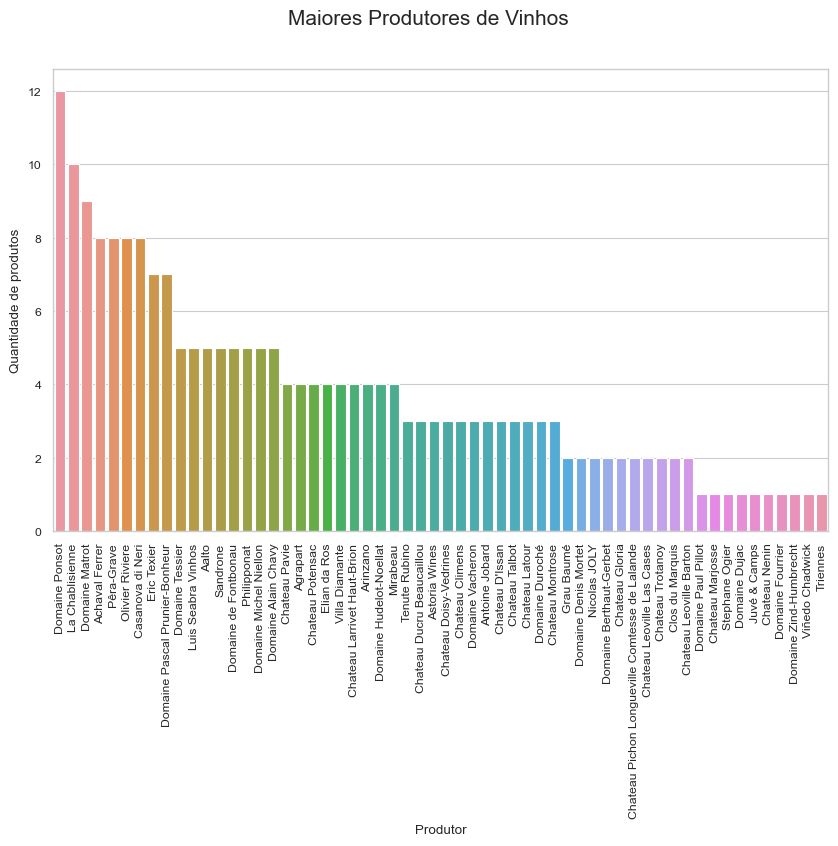

In [95]:
#plotando o grafico
fig, ax = plt.subplots()
sns.countplot(x=df_produtos.producer, order=df_produtos.producer.value_counts().index);
plt.xticks(rotation=90)
ax.set(xlabel='Produtor', ylabel='Quantidade de produtos')
fig.suptitle("Maiores Produtores de Vinhos", fontsize = 15)
plt.show();

Vamos ver a quantidade de vinhos por país.

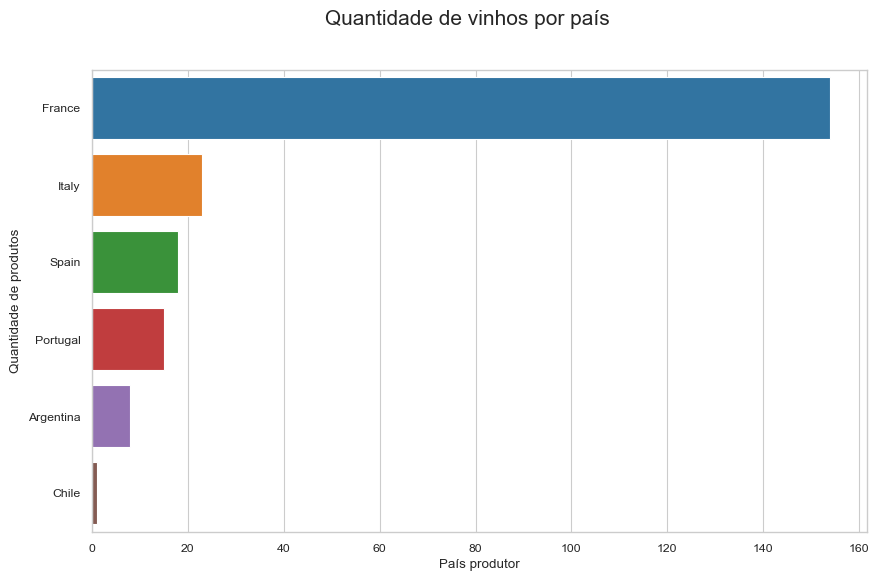

In [96]:
# plotando o grafico
fig, ax = plt.subplots()
sns.countplot(y=df_produtos.country, order=df_produtos.country.value_counts().index);
fig.suptitle("Quantidade de vinhos por país", fontsize = 15)
ax.set(xlabel='País produtor', ylabel='Quantidade de produtos')
plt.show();

**França** é o principal país produtor, com mais de 6 vezes a produção do segundo maior produtor, a **Itália**. \
\
Vamos visualizar a distribuição de tipos de vinho.

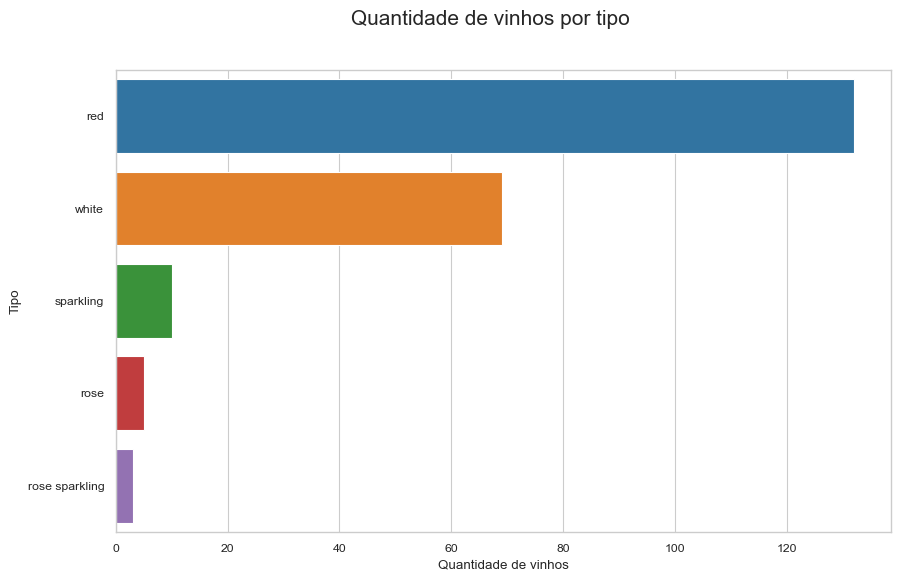

In [97]:
# plotando o gráfico
fig, ax = plt.subplots()
sns.countplot(y=df_produtos.kind, order=df_produtos.kind.value_counts().index);
fig.suptitle("Quantidade de vinhos por tipo", fontsize = 15)
ax.set(xlabel='Quantidade de vinhos', ylabel='Tipo')
plt.show();

Há predominância de vinhos **tintos**, **brancos** e **espumantes**. \
\
Vamos visualizar agora a quantidade de vinhos por safra, excluindo os vinhos com vintage=0

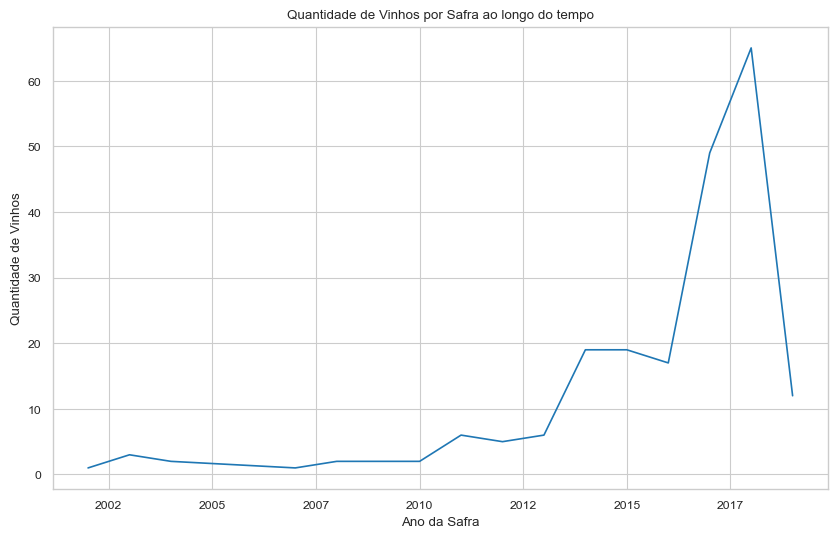

In [98]:
# filtrando apenas vinhos com safra e contando
df_safras = df_produtos[df_produtos.vintage != 0]
safra_count = df_safras.vintage.value_counts()

# plotando o gráfico
plt.figure()
ax = sns.lineplot(x=safra_count.index, y=safra_count.values)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.set(xlabel='Ano da Safra', ylabel='Quantidade de Vinhos')
ax.set_title("Quantidade de Vinhos por Safra ao longo do tempo")

plt.show()

Podemos ver que há maiores quantidade de vinhos de safras dos anos 2017 e 2018. \
\
Vamos agora anlisar quanto ao preço.

In [99]:
# descrevendo os preços
df_produtos[['vintage', 'price_brl', 'price_usd']].describe()

,vintage,price_brl,price_usd
count,219.000000,219.000000,219.000000
mean,1942.182648,967.617352,167.407808
std,379.055337,1409.588217,243.873780
min,0.000000,52.800000,9.130000
25%,2014.000000,264.300000,45.725000
50%,2017.000000,509.400000,88.130000
75%,2018.000000,949.200000,164.220000
max,2019.000000,10992.000000,1901.730000


Podemos observar que:

* A mediana está no ano de 2017, em conformidade com o apontamento a respeito do volume feito acima.
* O preço mínimo em real é R$52,80 e o máximo R$10.992,00.
* O preço médio em real é R$967,62.

In [100]:
# agrupando por região e obtendo o preço médio e a quantidade de produtos
df_regiao = df_produtos.groupby('region')['price_brl'].agg(['mean', 'count']).sort_values('mean', ascending=False)
df_regiao

,mean,count
region,,
Maipo,3594.000000,1
Ribera del Duero,2121.600000,5
Burgundy,1351.167143,70
Bordeaux,1222.606383,47
Piedmont,981.000000,5
Champagne,915.333333,9
Toscana,877.275000,8
Loire Valley,756.480000,5
Alsace,459.000000,1


As regiões com maior preço médio são **Maipo - Chile**, **Ribera del Duero - Espanha**, **Burgundy - França** e **Bordeaux - França**; porém podemos ver que Maipo tem apenas um vinho no dataset, enquanto Burgundy e Bordeaux tem juntos a maior quantidade de vinhos. \
\
Vamos visualizar os produtores de vinhos mais caros.

In [101]:
# agrupando por região e produtos para obter o preço médio e máximo
df_regiao = df_produtos.groupby(['country', 'producer'])['price_brl'].agg(['mean', 'max']).sort_values('mean', ascending=False)
df_regiao.head(5)

mean      max
country producer                         
France  Chateau Latour    5126.0   9594.0
        Domaine Ponsot    4057.5  10992.0
Chile   Viñedo Chadwick   3594.0   3594.0
France  Domaine Fourrier  3390.0   3390.0
        Domaine Dujac     3294.0   3294.0

Podemos ver que dos TOP 5 produtores com maior preço médio, 4 deles são da França, a saber **Chateau Latour**, **Domaine Ponsot**, **Domaine Fourrier**, **Domaine Dujac** e 1 deles é do Chile, do **Viñedo Chadwick**.

### Vendas

Para seguir, iremos mesclar o dataframe de vendas com o de produtos. Vamos visualizar o dataframe para ver as modificações necessárias.

In [102]:
df_vendas

,date,store,item,sales
0,2018-01-01,1,1,13
1,2018-01-02,1,1,11
2,2018-01-03,1,1,14
3,2018-01-04,1,1,13
4,2018-01-05,1,1,10
...,...,...,...,...
720066,12/27/2020,3,219,71
720067,12/28/2020,3,219,28
720068,12/29/2020,3,219,75
720069,12/30/2020,3,219,135


Iremos mudar o nome da coluna 'item' para 'item_id', mudar os tipos e fazer da coluna 'date' nosso novo índice. \
A coluna 'date' também tem datas em formatos diferentes, para isso, iremos passar o parâmetro format='mixed' na hora de converter o tipo da coluna.

In [103]:
# mudando o nome e o tipo da coluna
df_vendas.rename(columns={'item': 'item_id'}, inplace=True)
df_vendas['item_id'] = df_vendas['item_id'].astype(str)

# mesclando os dataframes
df_mesclado = df_produtos.merge(df_vendas, on='item_id', how='right')

# mudando o tipo da coluna date e setando como index
df_mesclado['date'] = pd.to_datetime(df_mesclado['date'], format='mixed')
df_mesclado.set_index('date', inplace=True)

# verificando as mudanças
df_mesclado.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales
date,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10


In [104]:
# verificando o novo dataframe
df_mesclado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720071 entries, 2018-01-01 to 2020-12-31
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   item_id    720071 non-null  object 
 1   name       720071 non-null  object 
 2   producer   720071 non-null  object 
 3   country    720071 non-null  object 
 4   region     720071 non-null  object 
 5   vintage    720071 non-null  int64  
 6   kind       720071 non-null  object 
 7   price_brl  720071 non-null  float64
 8   price_usd  720071 non-null  float64
 9   store      720071 non-null  int64  
 10  sales      720071 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 65.9+ MB


In [105]:
# descrevendo os dados de venda
round(df_mesclado['sales'].describe(), 2)

count    720071.00
mean         70.59
std          41.36
min           1.00
25%          35.00
50%          67.00
75%         104.00
max         196.00
Name: sales, dtype: float64

Olhando apenas para 'sales' vemos que a maior quantidade foi 196 e a menor é 1. A média fica em torno de 70.

Criando novas features com as informações de data e também a feature 'reveune', que é o valor gasto por item, em reais. Essas novas variáveis nos auxiliarão a extrair mais insights dos dados.

In [106]:
# criando uma cópia do dataset
store = df_mesclado.copy()

# criando mais features para a análise temporal
store["Year"] = store.index.year
store["Month"] = store.index.month
store["Weekday"] = store.index.weekday
store['Weekend'] = 0
store.loc[(store.Weekday == 5) | (store.Weekday == 6), 'Weekend'] = 1
store["Day"] = store.index.day
store["Dayofyear"] = store.index.dayofyear
store["Date"] = pd.DatetimeIndex(store.index).date
store.drop(store[store.Year == 2016].index, axis=0, inplace=True)
store['revenue'] = store['price_brl'] * store['sales']

# checando as novas features
store.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,Year,Month,Weekday,Weekend,Day,Dayofyear,Date,revenue
date,,,,,,,,,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,2018,1,0,0,1,1,2018-01-01,4414.8
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11,2018,1,1,0,2,2,2018-01-02,3735.6
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14,2018,1,2,0,3,3,2018-01-03,4754.4
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,2018,1,3,0,4,4,2018-01-04,4414.8
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10,2018,1,4,0,5,5,2018-01-05,3396.0


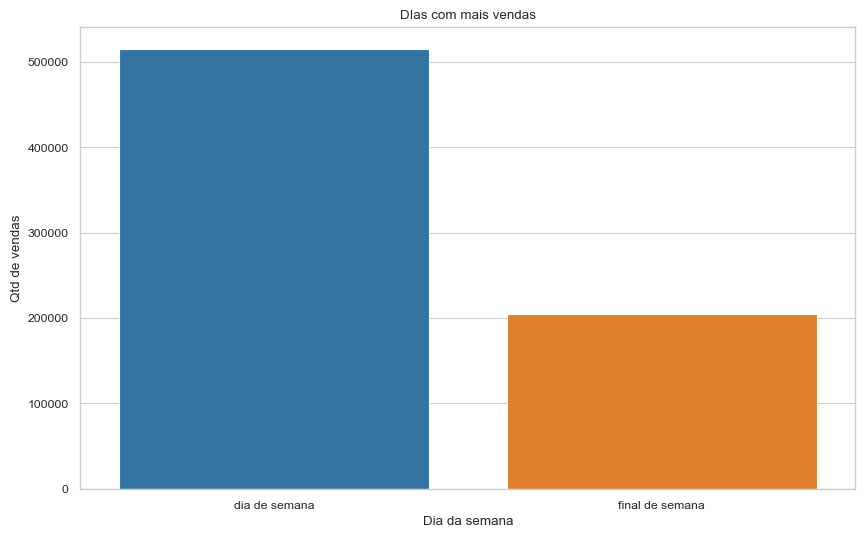

In [107]:
# checando valores por dia da semana
fds_count = store.Weekend.value_counts()
sns.barplot(x=fds_count.index, y=fds_count.values)
plt.ylabel("Qtd de vendas")
plt.xlabel("Dia da semana")
plt.title("DIas com mais vendas")
labels = ['dia de semana', 'final de semana']
plt.xticks(range(len(labels)), labels)
plt.show()

#### Análise de performance de venda

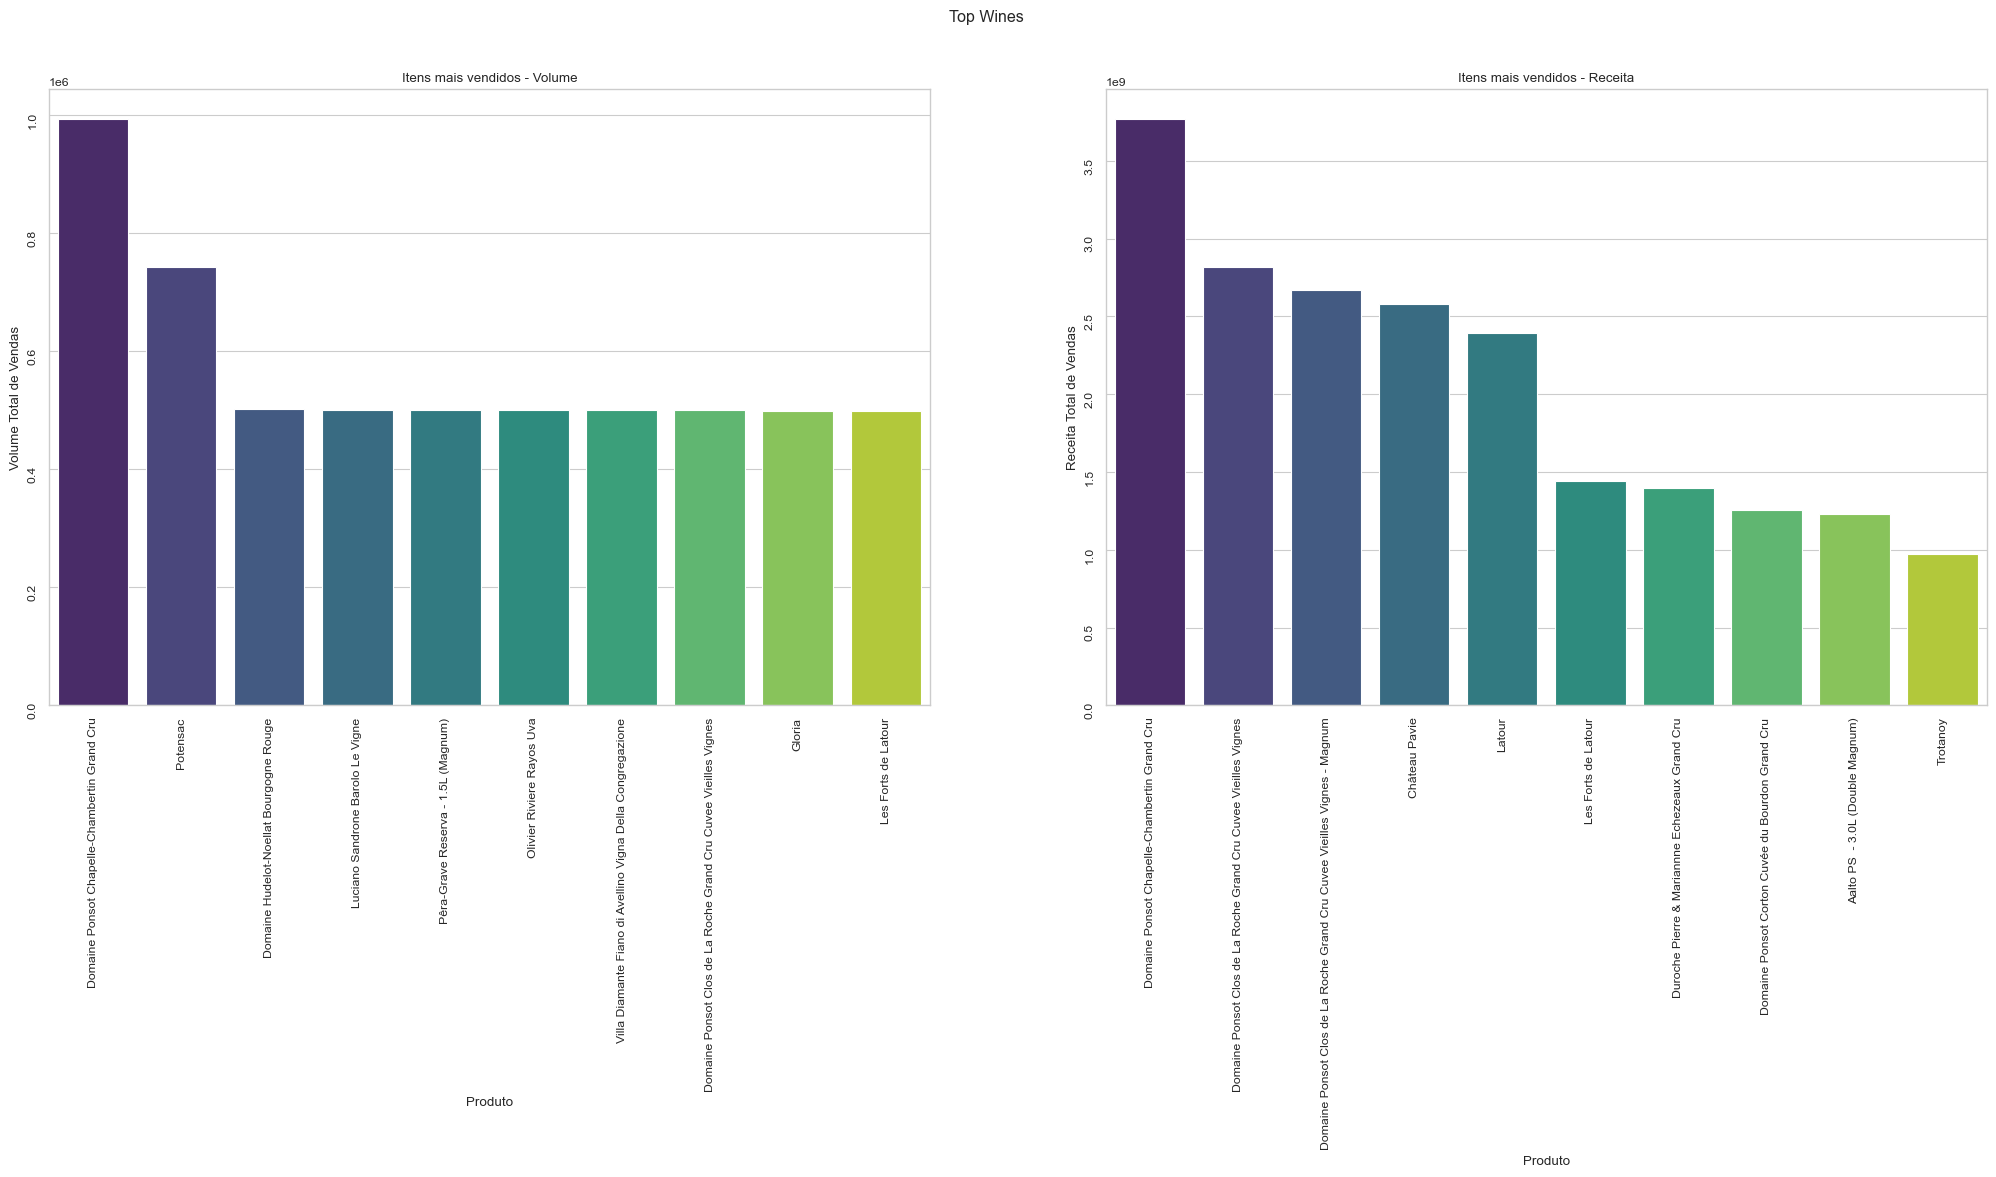

In [108]:
# visualizando os Top Sellers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (25,8))
fig.suptitle('Top Wines')

# 1. Itens mais vendidos em termos de volume
top_selling_volume = store.groupby('name')['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(10)
sns.barplot(x='name', y='sales', data=top_selling_volume, palette='viridis', ax=ax[0])
ax[0].tick_params(labelrotation=90)
ax[0].set_title('Itens mais vendidos - Volume')
ax[0].set_xlabel('Produto')
ax[0].set_ylabel('Volume Total de Vendas')

# 2. Itens mais vendidos em termos de receita gerada
top_selling_revenue = store.groupby('name')['revenue'].sum().reset_index().sort_values(by='revenue', ascending=False).head(10)
sns.barplot(x='name', y='revenue', data=top_selling_revenue, palette='viridis')
ax[1].tick_params(labelrotation=90)
ax[1].set_title('Itens mais vendidos - Receita')
ax[1].set_xlabel('Produto')
ax[1].set_ylabel('Receita Total de Vendas')

plt.show()

Temos aqui um detalhe interessante: o vinho que lidera em receita é também o de maior preço. No geral, o volume de faturamento acompanha o volume de vendas. Curiosamente, o vinho que ocupa a segunda posição em termos de receita é apenas o oitavo em quantidade de vendas.

A explicação para esse fenômeno é que os vinhos da Domaine Ponsot estão entre os caros altos oferecidos. De fato, eles representam os vinhos com os valores mais elevados do nosso catálogo.

Além disso, esse produtor se destaca por oferecer a maior variedade de rótulos, como vimos anteriormente.

Além de analisar a gama de vinhos que cada produtor oferece, é essencial entender como estão se saindo as vendas de cada um. Isso nos ajuda a pegar o pulso dos estilos de vinho que estão conquistando os corações (e paladares) dos clientes.

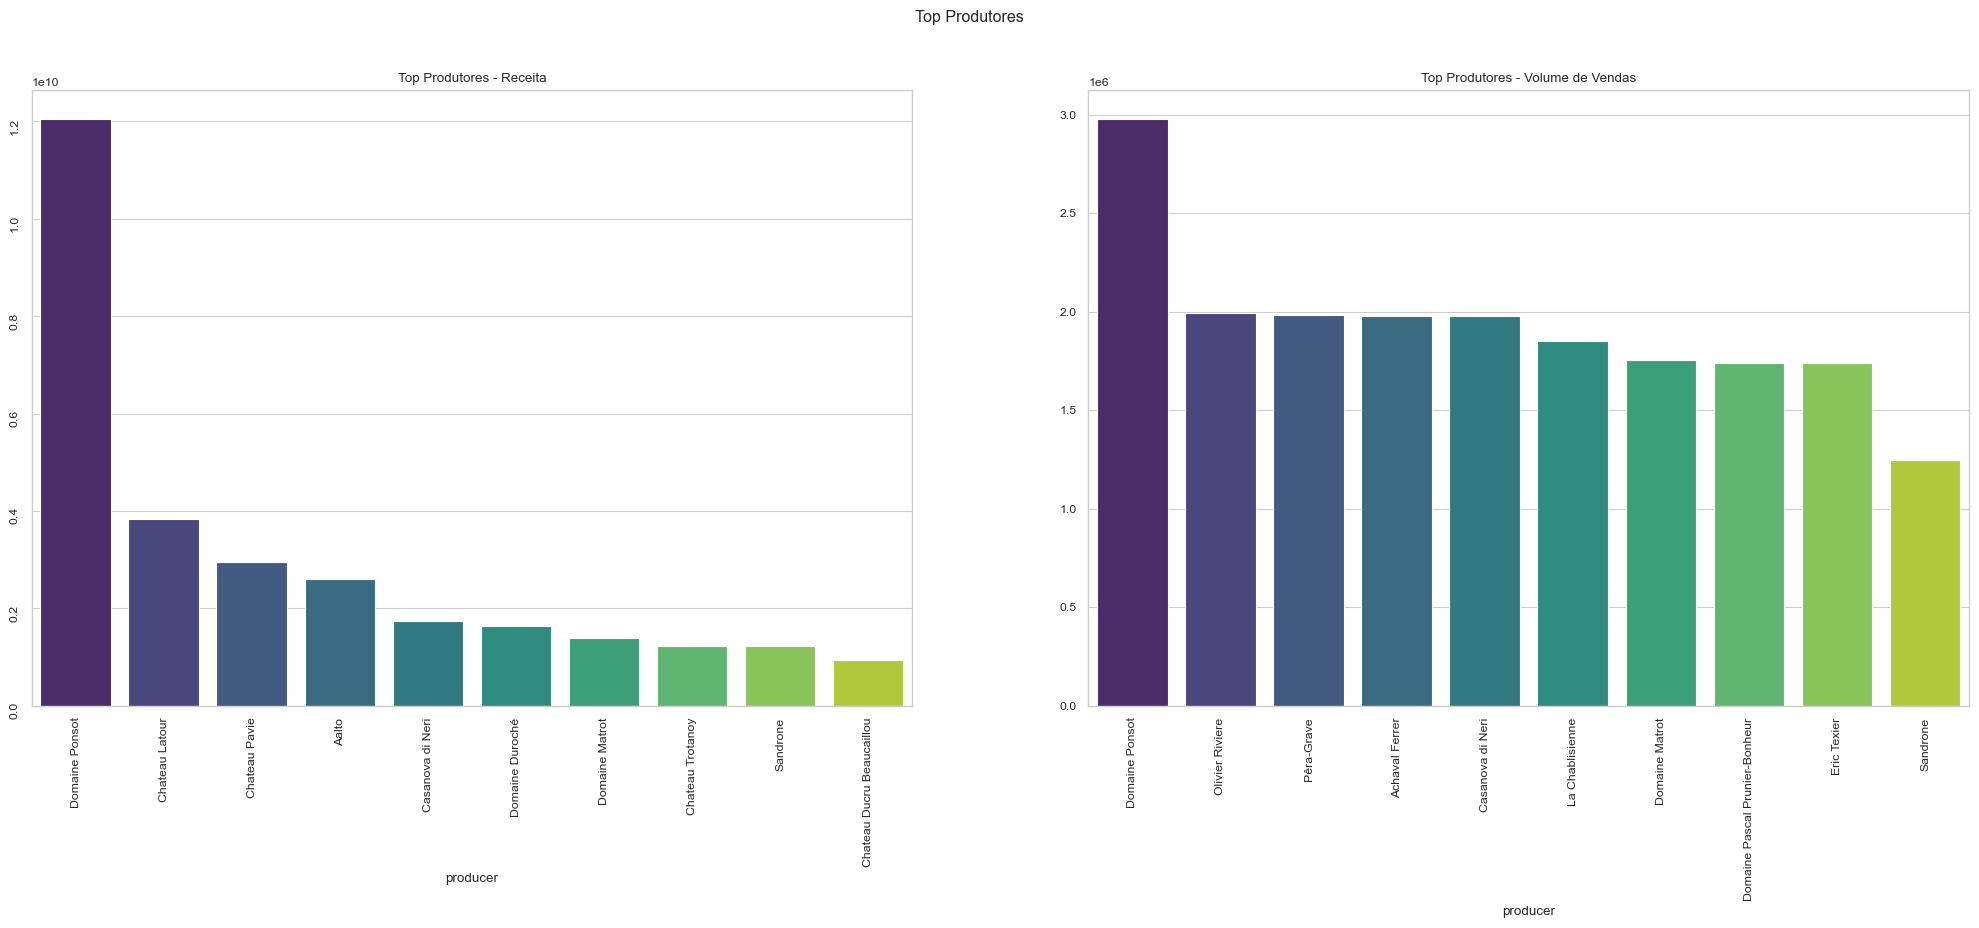

In [109]:
# visualizando os Top Produtores
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (25,8))
fig.suptitle('Top Produtores')

# produtores com mais receita
top_wines = store.groupby('producer')['revenue'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_wines.index, y=top_wines.values, palette="viridis", ax=ax[0])
ax[0].tick_params(labelrotation=90)
ax[0].set_title('Top Produtores - Receita')

# produtores com mais vendas
top_sales = store.groupby('producer')['sales'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_sales.index, y=top_sales.values, palette="viridis")
plt.xticks(rotation=90)
ax[1].set_title('Top Produtores - Volume de Vendas')

plt.show()

Neste cenário, o domínio da Domaine Ponsot se destaca novamente. No entanto, é interessante notar como o Chateau Latour ocupa a segunda posição em termos de receita, mesmo sem figurar entre os 10 primeiros em volume de vendas. Observamos também que a quantidade de vinhos disponíveis desse produtor é limitada, e os rótulos que temos são de valor mais alto. Isso nos leva a questionar: existe uma relação entre o preço dos vinhos e a quantidade de vendas?

#### Análise de preços

In [110]:
# descrevendo os dados de preço
df_mesclado.price_usd.describe()

count    720071.000000
mean        167.407801
std         243.316691
min           9.130000
25%          44.840000
50%          88.130000
75%         164.220000
max        1901.730000
Name: price_usd, dtype: float64

A distribuição dos preços é assimétrica à direita (média > mediana) e um valor máximo ($1901.73) bem acima do percentil 75 ($164.22). Esse comportamento é típico quando a maior parte dos produtos tem um valor alto. Possivelemnte a distribuição tem outliers.

Vamos avaliar a existência de valores extremos.

<Axes: xlabel='kind', ylabel='price_usd'>

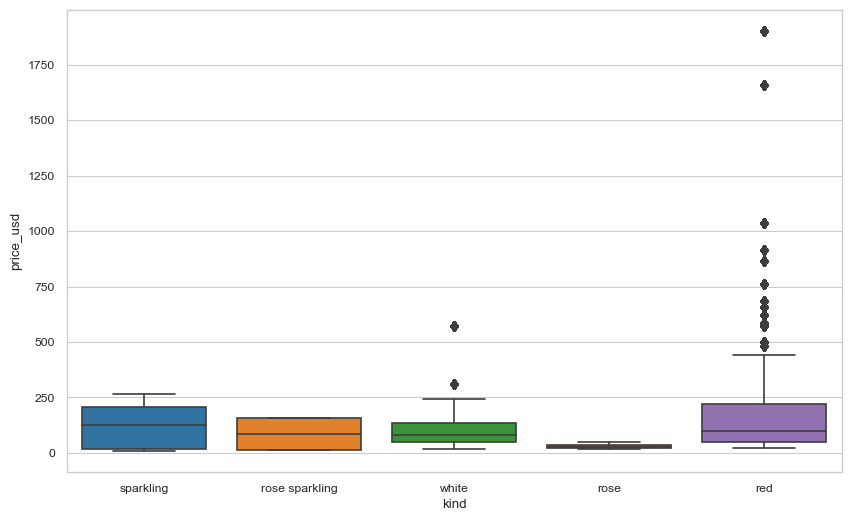

In [111]:
# plotando um boxplot por tipo
sns.boxplot(data=df_mesclado, y='price_usd', x='kind')

Conforme suspeitado, há muitos outliers nos preços, em especial de vinhos tintos, onde se concentra a maior parte dos produtos.

In [112]:
# top 5 vinhos mais caros
df_produtos.sort_values('price_usd', ascending = False)[['name','producer','country','region','vintage','kind','price_usd']].head(5)

,name,producer,country,region,vintage,kind,price_usd
93,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2017,red,1901.73
116,Latour,Chateau Latour,France,Bordeaux,2002,red,1659.86
142,Château Pavie,Chateau Pavie,France,Bordeaux,2010,red,1037.96
91,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2007,red,1037.02
92,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2017,red,915.57


Os 5 vinhos mais caros são todos da França, das regiões de Burgundy e Bordeaux. 4 dos 5 vinhos mais caros custam mais de $1.000, e são em média 8x mais caros que a média geral.

## 4 - Projeção de demanda

Vamos realizar projeções com os modelos Arima e Facebook Prophet.

In [113]:
store.head(3)

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,Year,Month,Weekday,Weekend,Day,Dayofyear,Date,revenue
date,,,,,,,,,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,2018,1,0,0,1,1,2018-01-01,4414.8
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11,2018,1,1,0,2,2,2018-01-02,3735.6
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14,2018,1,2,0,3,3,2018-01-03,4754.4


In [169]:
# preparando os dados
df = store.groupby('Date', as_index=False)['sales'].sum()
df.set_index('Date', inplace=True)

### Divisão treino/teste

Vamos utilizar os anos de 2018 e 2019 como treino e 2020 como teste.

In [179]:
df.index = pd.to_datetime(df.index)

train = df[df.index < pd.to_datetime('2020-01-01')]
test = df[df.index >= pd.to_datetime('2020-01-01')]

### Análises temporais

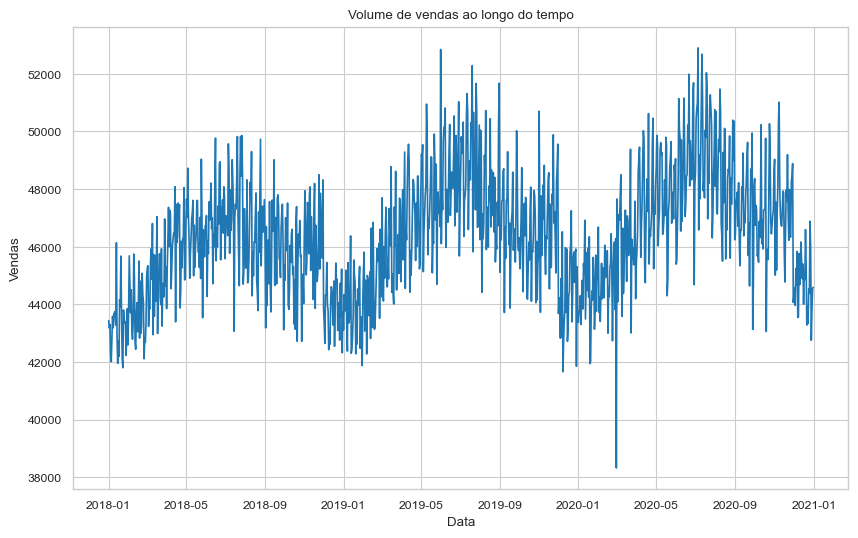

In [115]:
plot = sns.lineplot(data=df, x=df.index, y='sales')

plt.title('Volume de vendas ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Vendas')

plt.show()

Podemos destacar alguns aspectos do gráfico acima:
* Comportamento sazonal: Primeiro semestre do ano de crescimento e segundo semestre de declínio.
* Tendência de crescimento.
* há um ponto de anomalia com uma qudra brusca nas vendas

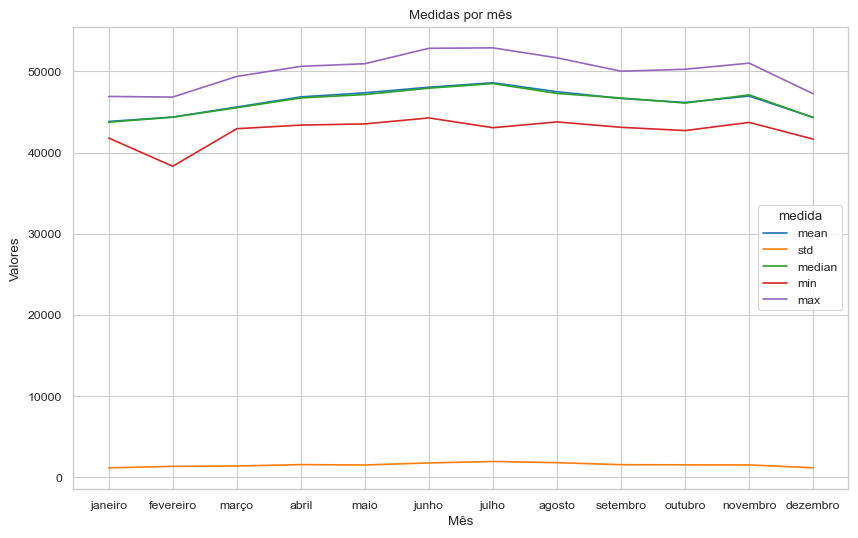

In [119]:
df.index = pd.to_datetime(df.index)
df['n_mes'] = df.index.month
df['mes'] = df['n_mes'].replace({1: 'janeiro', 2: 'fevereiro', 3: 'março', 4: 'abril', 5: 'maio', 6: 'junho',
                                            7: 'julho', 8: 'agosto', 9: 'setembro', 10: 'outubro', 11: 'novembro', 12: 'dezembro'})

# agrupa por mês e calcula estatisticas
agrupado = df.groupby(['n_mes','mes'], as_index=False)['sales'].agg(["mean", "std", "median", "min", "max"])
df_melted = agrupado.melt(id_vars='mes', value_vars=agrupado.columns[1:7], var_name='medida', value_name='valor')


sns.lineplot(data=df_melted, x='mes', y='valor', hue='medida')


plt.title('Medidas por mês')
plt.xlabel('Mês')
plt.ylabel('Valores')

plt.show()

* média e mediana caminhando próximas.
* junho e julho apresentando as maiores máximas, enquanto fevereriro apresenta menor mínima (valor atípico que vimos acima)
* desvio padrão estável ao longo do ano.

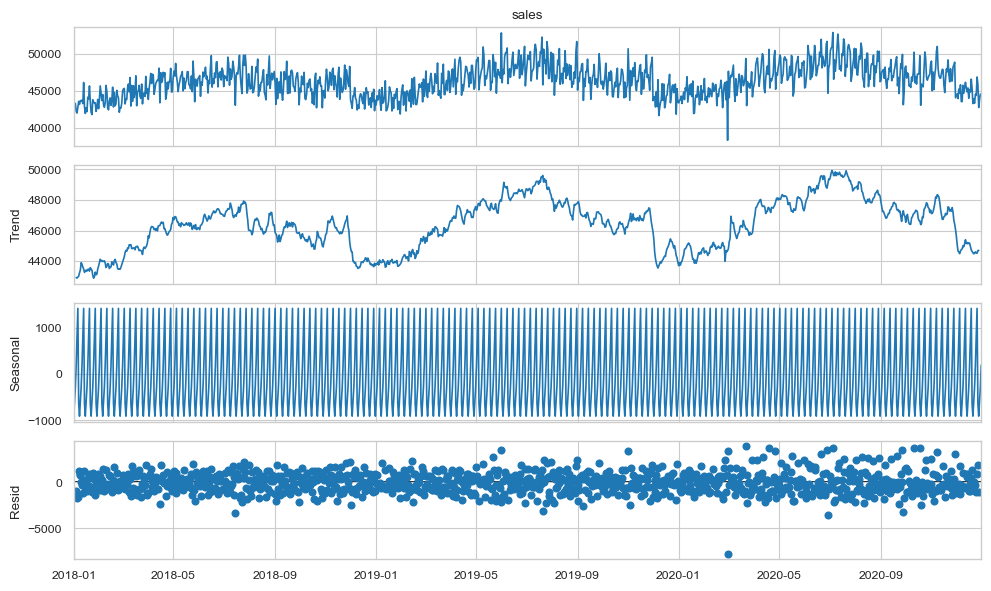

In [127]:
decomposition = seasonal_decompose(x = df['sales'], model = 'aditive')
decomposition.plot()

**1 - Tendência**: a série apresenta uma tendência de crescimento que oscila ao longo do tempo. \
**2 - Sazonalidade**: Padrões regurares claros em intervalos bem definidos (que não são possível de identificar visualmente nesse gráfico, provavelmente semanal).\
**3 - Resíduo**: componentes residuais se distribuindo de mandeira aleatória em torno do eixo e um ponto bem negativo, indicando a anomalia já mencionada anteriormente de mínima histórica no mês de fevereiro de 2020. \
\
No geral, a decomposição captura bem as características sazonais dos dados, e os padrão são claros e distintos. O gráfico indica que um modelo aditivo é o mais adequando para o problema, visto que a amplitude sazonal não acompanhou a amplitude do volume. O fato de podermos observar uma tendência de subida nos dados, já nos indica que se trata de uma série não estacionária.

### Estacionaridade

Os modelos do tipo AR e MA pressupoõem que os dados são estacionários (uma série temporal é considerada estacionária se suas propriedades estatísticas (como a média, a variância, a autocovariância) não mudam ao longo do tempo). Para termos certeza vamos testar a estacionaridade dos dados realizando o teste de Dickey-Fuller.

O teste funciona da seguinte forma:
temos duas hipóteses H0 e H1

H0: Hipótese Nula / Não é estacionário.
H1: Hipótese Alternativa / É estacionário.

O teste de Dickey-Fuller tentará provar, dentro de um intervalo de confiança, que a Hipótese Nula é verdadeira, ou seja, NÃO é estacionário.

In [130]:
adfuller_resultado = adfuller(df['sales'])
print('ADF Statistic: ', adfuller_resultado[0])
print('p-value: ', adfuller_resultado[1])

ADF Statistic:  -2.360051494446221
p-value:  0.15333037541347805


Tomando uma margem de erro de 5%, se de p>0.05 nós consideramos a hipótese nula como verdadeira. Ou seja, como nosso p-value é maior que 0.05, nosso teste indica que os dados NÃO são estacionários. \
Portanto precisamos transformar essa série em estacionária. Para isso utilizaremo so método diff() da biblioteca Pandas para diferenciar nossos dados até que o p-value se torne aceitável.

In [146]:
df_diff = df['sales'].diff().diff().diff().diff().diff().dropna()

# rodando novamente o teste de Dickey-Fuller para ver o p-value após diferenciar
diff_resultado_adfuller = adfuller(df_diff)
print('Diferenciação sobre o ADF Statistic: ', diff_resultado_adfuller[0])
print('Diferenciação sobre o p-value: ', diff_resultado_adfuller[1])

Diferenciação sobre o ADF Statistic:  -40.3057087899993
Diferenciação sobre o p-value:  0.0


In [156]:
df_diff = df_diff.to_frame()

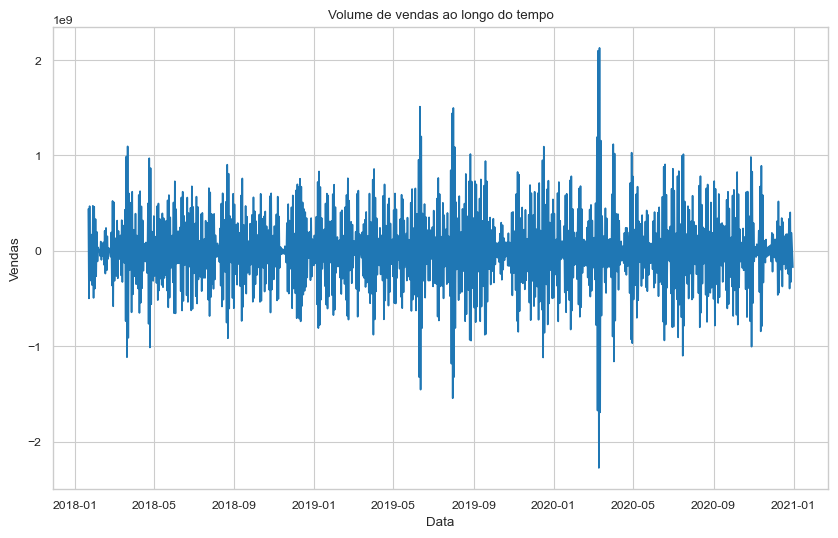

In [157]:
# visualizando após diferenciar
plot = sns.lineplot(data=df_diff, x=df_diff.index, y='sales')

plt.title('Volume de vendas ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Vendas')

plt.show()

Vamos analizar o correlograma da série após a diferenciação:

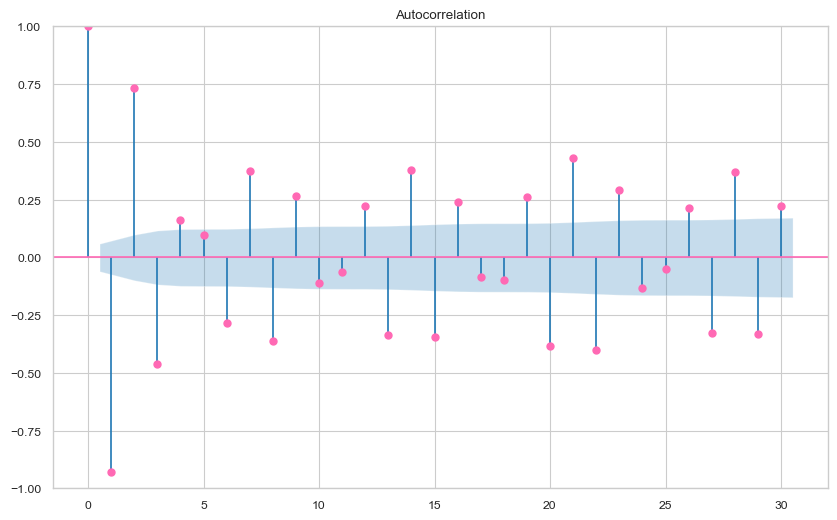

In [160]:
plot_acf(df_diff, lags=30,color='hotpink')
plt.show()

Muitos picos em lags indicam que a série não é aleatória e tem algum nível de dependência nos dados e algum padrão cíclico não claro.

Existe um provável processo MA na série.

Vamos analizar o correlograma parcial.

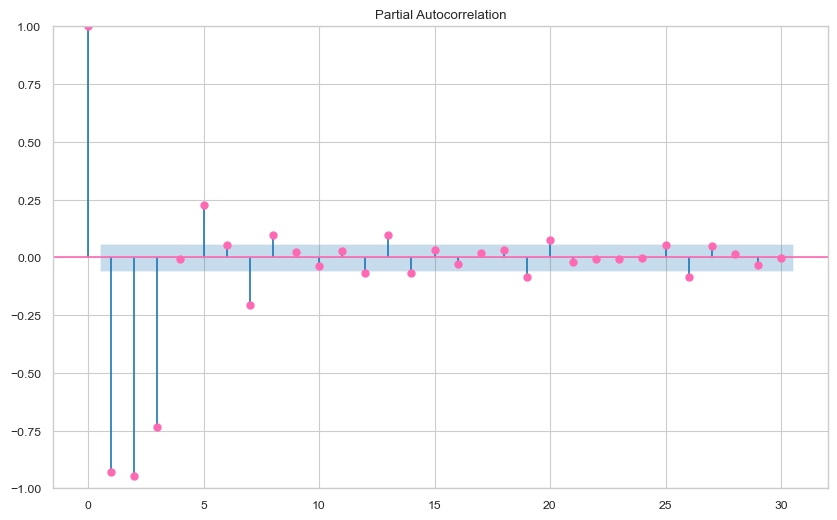

In [162]:
plot_pacf(df_diff, lags=30,color='hotpink')
plt.show()

Coeficientes de correlação altos nos lags 1,2,3 e 5 principalmente, sendo um possível indicador de um processo AR.

### ARIMA

O modelo ARIMA (AutoRegressive Integrated Moving Average) é uma técnica utilizada para análise e previsão de séries temporais. \
\
Ele combina componentes de autoregressão (AR), diferenciação integrada (I) e média móvel (MA) para modelar os padrões de variação ao longo do tempo. \
\
A parte autoregressiva considera as relações entre os valores passados da série, a média móvel incorpora o efeito de erros passados e a diferenciação integrada é aplicada para tornar a série estacionária, ou seja, com uma variância constante. \
\
Utilizamos o Auto-Arima porque ele automatiza a seleção dos hiperparâmetros do modelo ARIMA, como a ordem de autoregressão, a ordem de média móvel e o número de diferenças necessárias para estacionarizar a série. Isso torna o processo de modelagem mais eficiente e ajuda a evitar a necessidade de ajustes manuais demorados, permitindo uma abordagem mais orientada a dados na previsão de séries temporais.